In [1]:
# Copyright 2018-2020 Erasmus+ ICCT Project Consortium
#
# Redistribution and use in source and binary forms, with or without modification, 
# are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, 
# this list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice, 
# this list of conditions and the following disclaimer in the documentation and/or 
# other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its contributors
# may be used to endorse or promote products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, 
# INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.
# IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, 
# OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, 
# OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, 
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE 
# POSSIBILITY OF SUCH DAMAGE.

In [2]:
from IPython.display import HTML

# # Cell visibility - COMPLETE:
# tag = HTML('''<style> div.input {display:none;} </style>''')

#Cell visibility - TOGGLE:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<p style="text-align:right">
Toggle cell visibility <a href="javascript:code_toggle()">here</a>.</p>''')

display(tag)

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sympy as sym

from ipywidgets import widgets, Layout
from ipywidgets import interact

from IPython.display import Latex, display, Markdown # For displaying Markdown and LaTeX code

from matplotlib import patches

## Antenna azimuth position control system

An example of a simple antenna azimuth position control system is shown schematically in the left figure below. The goal of this control system is to maintain the reference (desired) position of the antenna by setting the desired angle $\theta_{ref}$ with the reference potentiometer (RP). Block diagram of this system (shown in the right figure below) therefore starts with the signal $\theta_{ref}$, which is converted to voltage $U_1$. Voltage $U_2$ is then subtracted from $U_1$. $U_2$ is the output from the measuring potentiometer (MP), which provides the information about the actual angle. Voltage difference $U_1-U_2$ represents the error that tells us how much the actual angle differs from the desired one. Based on this error the controller affects the electromotor, which (by means of gearing) rotates the antenna in the way in which the error is reduced. $d_w$ is a disturbance due to the wind, which randomly rotates the antenna.

<br>
<br>

<table>
    <tr>
        <th>Schematic representation of the antenna azimuth position control system</th>
        <th>Block diagram of the antenna azimuth position control system</th>
    </tr>
    <tr>
        <td><img src='img\antenna_azimuth_schematic.PNG'></td>
        <td><img src='img\antenna_azimuth_block-diagram.PNG'></td>
    </tr>
    <tr>
        <td></td>
        <td>Legend: RP-reference potentiometer, MP-measuring potentiometer, d<sub>w</sub>-disturbance due to the wind.</td>
    </tr>    
</table>

---

### How to use this notebook?

- Move the sliders to change the values of the desired antenna azimuth angle ($\theta_{ref}$), disturbance due to the wind ($d_w$), and proportional ($K_p$), integral ($K_i$) and derivative ($K_d$) tuning coefficients.

- Press the buttons to toggle between proportional (P), proportional-integral (PI) and proportional-integral-derivative (PID) controller type.

---

### Notes

- Size of the red arrow on the schematic representation of the antenna is proportional to the magnitude of the disturbance due to the wind ($d_w$), whereas the direction of the arrow indicates the direction of the disturbance.
- Dashed blue line on the schematic representation of an antenna denotes the actual angle of the atenna.
- Dashed green line on the schematic representation of an antenna denotes the desired angle of the atenna.
- Dash-dot red line on the schematic representation of an antenna indicates the previous actual angle of the antenna.

You can select between two different options for displaying the results:
1. Reset the schematic representation when the controller type is changed.
2. Reset the plot when the controller type is changed.

In [4]:
# define system constants
_Kpot = 0.318

_K1 = 100
_a = 100
_Km = 2.083
_am = 1.71
_Kg = 0.1
_R = 8
_Kt = 0.5
_Tv = 200 #in milliseconds

#set current theta and theta reference:
th = [0,0,0,0,0,0]
thref = [0,0,0,0,0,0]
# disturbance:
m = [0,0,0,0,0,0]
#joined together (first theta reference, second disturbance, then theta measured):
variables = [thref, m, th]

# variables of controller:
_K = 1
_taui = 1
_taud = 1


In [5]:
# symbolic calculus:
taui, taud, K, s, z = sym.symbols('taui, taud, K, s, z')

_alpha=0.1
#controller:
P = K
I = K/(taui*s)
D = K*taud*s/(_alpha*taud*s+1)

def make_model(controller):
    if controller == 'P':
        C = P
    elif controller == 'PI':
        C = P+I
    elif controller == 'PID':
        C = P+I+D
    else:
        print('Controller type not in library')
    
    tf_s = C*_K1*_Km*_Kg*_Kpot/(s*(s+_a)*(s+_am)+C*_K1*_Km*_Kg*_Kpot)
    tf_s = tf_s.simplify()

    tf_z = tf_s.subs(s,2/(_Tv/1000)*(z-1)/(z+1))
    tf_z = tf_z.simplify()
    
    num = [sym.fraction(tf_z.factor())[0].expand().coeff(z, i) for i in reversed(range(1+sym.degree(sym.fraction(tf_z.factor())[0], gen=z)))]
    den = [sym.fraction(tf_z.factor())[1].expand().coeff(z, i) for i in reversed(range(1+sym.degree(sym.fraction(tf_z.factor())[1], gen=z)))]
    #print(num)
    #print(den)

    tf_sM = _Km*_Kg*_R*(s+_a)/(s*(s+_a)*(s+_am)*_Kt+C*_K1*_Km*_Kg*_Kpot*_Kt)
    
    tf_zM = tf_sM.subs(s,2/(_Tv/1000)*(z-1)/(z+1))
    tf_zM = tf_zM.simplify()
    num_M = [sym.fraction(tf_zM.factor())[0].expand().coeff(z, i) for i in reversed(range(1+sym.degree(sym.fraction(tf_zM.factor())[0], gen=z)))]
    #print(num_M)
    #print(den_M)
    
    #print('\n........finished........')
    return sym.lambdify((K, taui, taud), [np.array(num), -np.array(num_M), -np.array(den)])

z_transform_p = make_model('P')
z_transform_pi = make_model('PI')
z_transform_pid = make_model('PID')

In [6]:
def calculate_next(z_transform):
    variables[-1][0] = 0 # set current to zero
    z_transform = z_transform(_K, _taui, _taud)
    
    temp = 0
    for i in range(len(z_transform)): # for every polynomial
        for j in range(len(z_transform[i])): # for every term in polynomial
            temp += z_transform[i][j] * variables[i][j]

    return temp / z_transform[-1][0]*(-1)

<IPython.core.display.Javascript object>


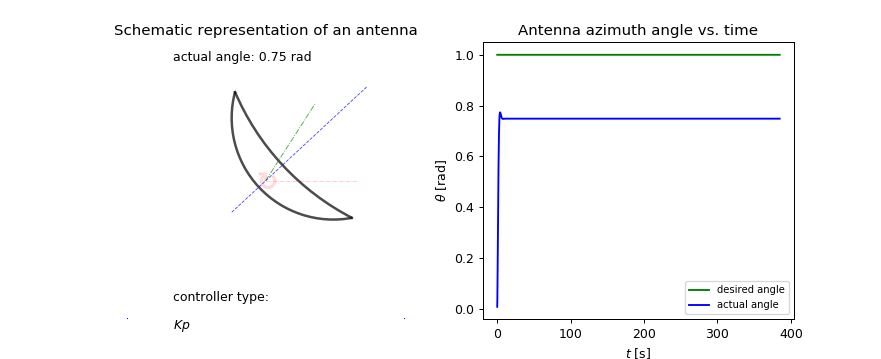

ToggleButtons(description='Select controller type:', options=('P', 'PI', 'PID'), style=ToggleButtonsStyle(desc…

In [7]:
fig = plt.figure(figsize=(9.8, 4),num='Antenna azimuth position control system')
# add axes
ax = fig.add_subplot(121)
graph = fig.add_subplot(122)
    
#set current theta and theta reference:
th = [0,0,0,0,0,0]
thref = [1,0,0,0,0,0]
# disturbance:
m = [.1,0,0,0,0,0]
#joined together (first theta reference, second disturbance, then theta measured):
variables = [thref, m, th]

# variables of controller:
_K = 20
_taui = 10
_taud = 1

new_flag_value = [True, 0] # flag for displaying old value of th, before th_ref was changed [flag, angle]

#slider widgets:
th_ref_widget = widgets.FloatSlider(value=variables[0][0],min=0.0,max=2*np.pi,step=.01,description=r'\(\theta_{ref} \) [rad]',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
m_widget = widgets.FloatSlider(value=variables[1][0],min=-.3,max=.3,step=.01,description=r'\(d_{w} \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
K_widget = widgets.FloatSlider(value=_K,min=0.0,max=40,step=.1,description=r'\(K_p \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.1f')
taui_widget = widgets.FloatSlider(value=_taui,min=0.01,max=60,step=.01,description=r'\(K_i \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
taud_widget = widgets.FloatSlider(value=_taud,min=0.0,max=5,step=.1,description=r'\(K_d \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
#interact(set_coefficients, setK=K_widget, setthref=th_ref_widget, setm=m_widget, settaui=taui_widget, settaud=taud_widget)

#checkboxes
#checkbox_reset_antenna = widgets.Checkbox(value=False, description='Reset schematic representation of antenna when type of controller is changed', disabled=False)
#checkbox_reset_graph = widgets.Checkbox(value=False, description='Reset graph when type of controller is changed', disabled=False)

checkbox_reset_antenna = widgets.Checkbox(value=False, disabled=False, layout=Layout(width='100px'))
label_scheme = widgets.Label('Reset schematic representation of the antenna when the controller type is changed', layout=Layout(width='500px'))
box1 = widgets.HBox([checkbox_reset_antenna, label_scheme])
                             
checkbox_reset_graph = widgets.Checkbox(value=False, disabled=False, layout=Layout(width='100px'))
label_graph = widgets.Label('Reset "Antenna azimuth angle vs. time" diagram when the controller type is changed', layout=Layout(width='500px'))
box2 = widgets.HBox([checkbox_reset_graph, label_graph])

style = {'description_width': 'initial'}

#buttons:
def buttons_clicked(event):
    global controller_type, equation, list_th, list_th_ref, list_time
    controller_type = buttons.options[buttons.index]
    if controller_type =='P':
        taui_widget.disabled=True
        taud_widget.disabled=True
        equation = '$Kp$'
    if controller_type =='PI':
        taui_widget.disabled=False
        taud_widget.disabled=True
        equation = '$Kp\,(1+\dfrac{1}{T_{i}\,s})$'
    if controller_type =='PID':
        taui_widget.disabled=False
        taud_widget.disabled=False
        equation = '$Kp\,(1+\dfrac{1}{T_{i}\,s}+\dfrac{T_{d}\,s}{a\,T_{d}\,s+1})$'
    if checkbox_reset_antenna.value:
        #reset values to zero:
        for i in range(len(variables)):
            for j in range(1, len(variables[i])):
                variables[i][j] = 0
        variables[-1][0] = 0
    if checkbox_reset_graph.value:
        list_th = []
        list_th_ref = []
        list_time = []
        
buttons = widgets.ToggleButtons(
    options=['P', 'PI', 'PID'],
    description='Select controller type:',
    disabled=False,
    style=style)
buttons.observe(buttons_clicked)


#updating values
def set_values(event):
    global _K, _taui, _taud
    if event['name'] != 'value':
        return
    if th_ref_widget.value != variables[0][0] and not new_flag_value[0]:
        new_flag_value[0] = True
        new_flag_value[1] = variables[-1][0]
        
    variables[0][0] = th_ref_widget.value
    variables[1][0] = m_widget.value
    _K = K_widget.value
    _taui = taui_widget.value
    _taud = taud_widget.value
th_ref_widget.observe(set_values)
m_widget.observe(set_values)
K_widget.observe(set_values)
taui_widget.observe(set_values)
taud_widget.observe(set_values)

#displaying widgets:
display(buttons)
vbox1 = widgets.VBox([th_ref_widget, m_widget, K_widget, taui_widget, taud_widget])
vbox2 = widgets.VBox([box1, box2])
hbox = widgets.HBox([vbox1, vbox2])
display(hbox)

#setting at start:
controller_type = 'P'
taui_widget.disabled=True
taud_widget.disabled=True
equation = '$Kp$'
set_values({'name':'value'})

#lists for graph in time:
list_time = []
list_th = []
list_th_ref = []

#previous th before change of th_ref:
prev_th = 0

cycles_flag = True

def update_figure(i_time):
    global cycles_flag, variables, _K, controller_type, equation
    
    if cycles_flag == True:
        cycles_flag = False
        return
    
    if controller_type == 'P':
        th = calculate_next(z_transform_p)
    elif controller_type == 'PI':
        th = calculate_next(z_transform_pi)
    elif controller_type == 'PID':
        th = calculate_next(z_transform_pid)
    variables[-1][0] = th
    
    # save variables for next time step:
    for i in range(len(variables)):
        for j in reversed(range(len(variables[i])-1)):
            variables[i][j+1] = variables[i][j]

    list_time.append((i_time+1)*_Tv/1000)
    list_th.append(th)
    list_th_ref.append(variables[0][0])
    
    #plot:
    ax.clear()
    ax.plot([-1.5, 1.5, 1.5, -1.5], [-1.5, -1.5, 1.5, 1.5], ',', color='b')
    
    #plot line:
    ax.plot([np.cos(th)*-.5, np.cos(th)*1.5], [np.sin(th)*-.5, np.sin(th)*1.5], 'b--', linewidth=.7, alpha=.7)
    
    #plot antenna:
    center1 = 1
    center2 = 3
    d1 = 2.2
    d2 = 5.5
    x1 = center1*np.cos(th)
    y1 = center1*np.sin(th)
    x2 = center2*np.cos(th)
    y2 = center2*np.sin(th)
    arc1 = patches.Arc((x1, y1), d1, d1,
                 angle=th/np.pi*180+180, theta1=-58, theta2=58, linewidth=2, color='black', alpha=.7)
    arc2 = patches.Arc((x2, y2), d2, d2,
                 angle=th/np.pi*180+180, theta1=-20, theta2=20, linewidth=2, color='black', alpha=.7)
    ax.add_patch(arc1)
    ax.add_patch(arc2)
    if m_widget.value > 0:
        ax.plot(0, 0, 'r', alpha=.1, marker=r'$\circlearrowright$',ms=150*m_widget.value)
    elif m_widget.value < 0:
        ax.plot(0, 0, 'r', alpha=.1, marker=r'$\circlearrowleft$',ms=-150*m_widget.value)
    ax.set_title('Schematic representation of an antenna')

    
    #plot direction of antenna before thref change
    if abs(variables[0][0] - th) < 0.03:
        new_flag_value[0] = False
    if new_flag_value[0]:
        ax.plot([0,np.cos(new_flag_value[1])], [0, np.sin(new_flag_value[1])], 'r-.', alpha=.3, linewidth=0.5)
    #plot desired direction of antenna
    ax.plot([0,np.cos(variables[0][0])], [0, np.sin(variables[0][0])], 'g-.', alpha=.7, linewidth=0.7)
    
    ax.text(-1, 1.3, 'actual angle: %.2f rad' %th)
    ax.text(-1, -1.3, 'controller type:')
    ax.text(-1, -1.6, equation)
    
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.axis('off')
    
    graph.clear()
    graph.plot(list_time, list_th_ref, 'g', label='desired angle')
    graph.plot(list_time, list_th, 'b', label='actual angle')    
    graph.set_xlabel('$t$ [s]')
    graph.set_ylabel('$\\theta$ [rad]')
    graph.legend(loc=4, fontsize=8)
    graph.set_title('Antenna azimuth angle vs. time')
    
    plt.show()

ani = animation.FuncAnimation(fig, update_figure, interval=_Tv)